In [ ]:
#pip install tslearn

In [95]:
import glob
import numpy as np 
import time
import math
import random
from scipy import linalg as LA
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from termcolor import colored
import csv
import scipy.io
#import tslearn
#from tslearn.metrics import dtw

In [96]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Reading and preprocessing data

In [97]:
mat = scipy.io.loadmat('/content/gdrive/My Drive/Research/Characters/mixoutALL_shifted.mat')

In [98]:
labels = mat['consts'][0][0][4][0]
labels

array([ 1,  1,  1, ..., 20, 20, 20], dtype=uint8)

In [99]:
data = [0] * len(mat['mixout'][0])
for j in range(len(data)):
    data[j] = [0] * len(mat['mixout'][0][j][0])
    data[j][0] = np.zeros(2)
    for i in range(1, len(mat['mixout'][0][j][0])):
        data[j][i] = data[j][i-1] + mat['mixout'][0][j][:2, i]
    data[j] = np.array(data[j])
        
data = np.array(data, dtype=object)
data.shape

(2858,)

In [100]:
np.random.seed(10)
I = np.random.permutation(len(data))[:300]
data = data[I]

In [101]:
I

array([ 174,  449,  778,  543,   29, 1942, 2098, 2669, 2040, 2716, 2499,
       2537, 2154, 2288, 2749, 1361, 1264, 1161,   25, 1724,  148, 2142,
       2774,  855, 1206, 1935, 2300,  755, 2250, 1094, 2282, 1985,  854,
       2235, 2706,  437,  264, 1352, 2579, 1559, 1144,  775,  263,  934,
       1400,  101,  887, 2540, 1869, 1451, 1745, 1708, 2375, 1122, 1769,
       2464, 2448, 2143, 1567, 2071, 2592,  621, 1822,  539,  528,  729,
       2101, 1179, 2790, 1511, 1529, 1506, 1249, 2238,  353,  230, 1631,
         37, 1059, 1132, 2077, 2004,  311, 1292,  210, 2772, 1145, 2616,
       1695, 1357,  510, 1101, 1051,  484,  764, 2713, 2123,  822, 1356,
        579,  379,  839, 2211, 2019,  701, 2161, 1620, 2536, 1592, 1734,
        592,  948, 1175,  945, 2436, 1593, 2029, 2738, 1893,  828, 1358,
         95, 1588, 2387,  492, 1775, 2595,   85, 1035,  219, 1933, 2153,
       1068, 1485, 1036, 1947, 1719, 1680, 1850, 1141, 2186, 2139, 2259,
       1167, 1845,  604,  731,  196,  235, 2744,  7

# DTW distances

In [8]:
def calculate_dists_dtw_tslearn(data, path): 
    start_time = time.time() 
    n = len(data)
    A = []
    for i in range(n-1):
        for j in range(i+1, n):
            A.append(tslearn.metrics.dtw(data[i], data[j]))
    A = np.array(A)
    tri = np.zeros((n, n))
    tri[np.triu_indices(n, 1)] = A
    for i in range(1, n):
        for j in range(i):
            tri[i][j] = tri[j][i]
    np.savetxt(path, tri, delimiter=',')

    total_time = time.time() - start_time
    return total_time

In [102]:
path = '/content/gdrive/My Drive/IR Project/Characters/'

In [103]:
# Run just for once
#calculate_dists_dtw_tslearn(data, path=path+'dtw-characters.csv')

In [104]:
dists_dtw = np.array(pd.read_csv(path+'dtw-characters.csv', header=None))
dists_df = pd.read_csv(path+'dtw-characters.csv', header=None)
#dists[:5, :5]
dists_df.head()[[0,1,2,3,4,5,6,7,8,9]]

,0,1,2,3,4,5,6,7,8,9
0,0.000000,73.217389,70.737265,105.108616,85.428258,75.122541,85.666920,106.827505,106.043748,84.374732
1,73.217389,0.000000,50.492406,31.401462,34.971335,49.513084,41.827890,55.573685,33.748713,27.762267
2,70.737265,50.492406,0.000000,63.140881,38.499044,36.876185,30.871332,40.029573,63.922013,39.504046
3,105.108616,31.401462,63.140881,0.000000,40.013779,64.026406,48.592620,52.143227,14.000957,34.277480
4,85.428258,34.971335,38.499044,40.013779,0.000000,34.251575,28.390781,33.562414,42.144397,32.077731


In [105]:
dists_dtw.shape

(2858, 2858)

In [106]:
ranked_inverted_index_dtw = np.argsort(dists_dtw, 1)

In [107]:
#np.savetxt(path+'ranked_inverted_index_dtw.csv', ranked_inverted_index_dtw, delimiter=',')

In [108]:
ranks_dtw = np.vectorize(int)(np.array(pd.read_csv(path+'ranked_inverted_index_dtw.csv', header=None)))
ranks_dtw

array([[   0,   22,   73, ..., 1337, 1336, 2710],
       [   1,   12,    9, ..., 1337, 2710, 2095],
       [   2,   49,   13, ..., 1336, 2710, 2095],
       ...,
       [2855, 2845, 2854, ..., 1336, 1337, 2710],
       [2856, 1352, 2833, ..., 1336, 1337, 2710],
       [2857, 2844, 2849, ..., 1336, 1337, 2710]])

In [109]:
dists_dtw = dists_dtw[I][:,I]
dists_dtw.shape

(300, 300)

In [110]:
ranks_dtw = ranks_dtw[I][:, I]
ranks_dtw.shape

(300, 300)

# Vectorizing trajectories

## Functions

In [111]:
n_x_grids = 50
n_y_grids = 50
path = '/content/gdrive/My Drive/IR Project/Characters/'
sigma_coeff = 3
M = len(data)
reduction_dim = 25
option= 'binary' #'multipass'
max_limit = 50

In [112]:
def getGridsXAndY(data, n_x_grids, n_y_grids, path=None):
    '''
    path = '/content/gdrive/My Drive/IR Project/Characters/'
    return: x, y-linspaces in the rectangle (x_min, y_min), (x_max, y_max)
    '''
    x_min, y_min = np.min([np.min(data[i], axis=0) for i in range(len(data))], axis=0)
    x_max, y_max = np.max([np.max(data[i], axis=0) for i in range(len(data))], axis=0)
    x_margin = 0.01 * (x_max - x_min)
    y_margin = 0.01 * (y_max - y_min)
    x = np.linspace(x_min - x_margin, x_max + x_margin, n_x_grids+1)
    y = np.linspace(y_min - y_margin, y_max + y_margin, n_y_grids+1)
    if path:
        np.savetxt(path+"x.csv", x.reshape(1, len(x)), delimiter=",")
        np.savetxt(path+"y.csv", y.reshape(1, len(y)), delimiter=",")
        np.savetxt(path+"minMaxs.csv", [x_min, y_min, x_max, y_max], delimiter="'")
    return x, y, x_min, y_min, x_max, y_max

In [113]:
x, y, x_min, y_min, x_max, y_max = getGridsXAndY(data, n_x_grids, n_y_grids, path)
n_x_grids = len(x) - 1
n_y_grids = len(y) - 1

In [114]:
def centersSimilarityMatrix(sigma_coeff=5, path=None):
    '''
    Gives the similarity matrix of centers of grids using Gauusian kernel
    '''
    tensor = np.zeros((n_x_grids, n_y_grids, 2))
    for i in range(n_x_grids):
        for j in range(n_y_grids): # range(self.n_y_grids - 1, -1, -1)
            tensor[i][j] = [(x[i]+x[i+1])/2, (y[j]+y[j+1])/2]
    tensor = tensor.reshape(-1,2)
    simMatrix = np.ones((len(tensor), len(tensor)))
    sigma = sigma_coeff * ((y_max-y_min)+(x_max-x_min))/(n_x_grids + n_y_grids)
    for i in range(len(tensor) - 1):
        simMatrix[i][i+1:] = np.exp(-np.sum((tensor[i+1:]-tensor[i])*(tensor[i+1:]-tensor[i]), 
                                             axis=1)/sigma**2)
    for i in range(len(tensor) - 1):
        simMatrix[:,i][i+1:] = simMatrix[i][i+1:]
    return simMatrix

In [115]:
C = centersSimilarityMatrix(sigma_coeff, path=None)
C.shape

(2500, 2500)

In [116]:
def vectorizeLineSegment(LineSegment): 
    '''
    LineSegment: of shape (2, 2); coordinates of start and end are given; [[x1, y1], [x2, y2]]
    return: a binary vector of length n_x_grids x n_y_grids, which shows if 
            LineSegment has occured in each grid or not
    '''
    array = np.zeros((n_x_grids, n_y_grids))
    p1, p2 = LineSegment
    slope = (p2-p1)[1]/((p2-p1)[0] + 1e-10)
    i1 = np.where(x - p1[0] < 0)[0][-1]
    i2 = np.where(x - p2[0] < 0)[0][-1]
    xIdxStart = min(i1, i2)
    xIdxEnd = max(i1, i2)

    if xIdxEnd != xIdxStart:
        ''' dealing with start point of lineSegment'''
        if i1 < i2:
            j_start = np.where(y - p1[1] < 0)[0][-1]
            y_val_end = slope * (x[i1+1] - p1[0]) + p1[1]
        else:
            j_start = np.where(y - p2[1] < 0)[0][-1]
            y_val_end = slope * (x[i2+1] - p1[0]) + p1[1]
        j_end = np.where(y - y_val_end < 0)[0][-1]
        array[xIdxStart][np.arange(min(j_start, j_end), max(j_start, j_end)+1)] = 1

        ''' dealing with end point of lineSegment'''
        if i1 < i2:
            j_end = np.where(y - p2[1] < 0)[0][-1]
            y_val_start = slope * (x[i2] - p1[0]) + p1[1]
        else:
            j_end = np.where(y - p1[1] < 0)[0][-1]
            y_val_start = slope * (x[i1] - p1[0]) + p1[1]
        j_start = np.where(y - y_val_start < 0)[0][-1]
        array[xIdxEnd][np.arange(min(j_start, j_end), max(j_start, j_end)+1)] = 1

        ''' dealing with non-endpoints of lineSegment'''
        for i in range(xIdxStart+1, xIdxEnd):
            y_val_start = slope * (x[i] - p1[0]) + p1[1]
            y_val_end = slope * (x[i+1] - p1[0]) + p1[1]
            j_start = np.where(y - y_val_start < 0)[0][-1]
            j_end = np.where(y - y_val_end < 0)[0][-1]
            array[i][np.arange(min(j_start, j_end), max(j_start, j_end)+1)] = 1
    else:
        y_val_start = min(p1[1], p2[1])
        y_val_end = max(p1[1], p2[1])
        j_start = np.where(y - y_val_start < 0)[0][-1]
        j_end = np.where(y - y_val_end < 0)[0][-1]
        array[xIdxStart][np.arange(min(j_start, j_end), max(j_start, j_end)+1)] = 1
    return array.reshape(n_x_grids * n_y_grids)

In [117]:
def vectorizeTrajectory(trajectory, option): # T --> T_tilda
    '''
    trajectory: of shape (m, 2)
    return: a vector of length n_x_grids x n_y_grids, which shows the number 
            of occurences of trajectory in each grid
    '''
    A = [vectorizeLineSegment(trajectory[i:i+2]) for i in range(len(trajectory) - 1)]
    if option == 'multipass':
        return np.sum(A, axis=0)
    elif option == 'binary':
        return np.sign(np.sum(A, axis=0))


def vectorizeData(data, option): # data --> D_tilda
    ''' 
    vectorizes vectorizeTrajectory() over data 
    '''
    mappedData = [vectorizeTrajectory(data[i], option) for i in range(len(data))]
    return np.array(mappedData).T

In [118]:
start_time = time.time()
print("option:", option)
D_tilda = vectorizeData(data, option)
print(time.time() - start_time)

option: binary
2.2215585708618164


In [119]:
import scipy 

def dimReductionData(data, option, reduction_dim, path=None):
    '''
    Performs dimentionality reduction using SVD of similarity matrix C of centers of grids
    path='/content/gdrive/My Drive/IR Project/'
    '''
    D_tilda = vectorizeData(data, option)
    Delta, P = np.linalg.eigh(C, UPLO='L')
    I = np.where(Delta <= 1e-15)[0]
    Delta[I] = 0
    Delta_0 = Delta 
    D_tilda_tilda = np.diag(np.sqrt(Delta_0)) @ P.T @ D_tilda
    U, S, Vt = scipy.linalg.svd(D_tilda_tilda)
    U_e = U[:, :reduction_dim] 
    if path:
        np.savetxt(path+"Delta_0_sqrt_"+option+".csv", np.sqrt(Delta_0).reshape(1,len(Delta_0)), delimiter=',')
        np.savetxt(path+"Pt_"+option+".csv", P.T, delimiter=',')
        np.savetxt(path+"U_e_"+option+".csv", U_e, delimiter=',')
    return np.sqrt(Delta_0), P.T, U_e, U_e.T @ D_tilda_tilda

In [120]:
s = time.time()
print('option:', option)
Delta_0_sqrt, Pt, U_e, reducedData = dimReductionData(data, option, reduction_dim, path)

print(reducedData.shape)
print(time.time() - s)

option: binary
(25, 300)
21.848055839538574


In [121]:
def gridAggregateDist(traj1, traj2, option):
    '''
    Calculates the Grid Aggregated Distance between two trajectories traj1 and traj2 
    with respect to centers matrix C; normalized by the number of grids
    '''
    traj_1 = vectorizeTrajectory(traj1, option)
    traj_2 = vectorizeTrajectory(traj2, option)
    dist = ((traj_1 - traj_2).T @ Pt.T @ np.diag(Delta_0_sqrt**2) @ Pt @ (traj_1 - traj_2))
    return np.sqrt(dist)/(n_x_grids * n_y_grids)

In [122]:
def gridAggregateDistVectorized(traj_vectorized, data_vectorized, option):
    '''
    Calculates the Grid Aggregated Distance between traj_vectorized and data_vectorized 
    (which is an array of vectorized trajectories) with respect to centers matrix C; 
    normalized by the number of grids
    '''
    c = np.diag(Delta_0_sqrt) @ Pt @ (data_vectorized - traj_vectorized).T
    dists = np.sum(c * c, 0)
    return np.sqrt(dists)/(n_x_grids * n_y_grids)

In [123]:
def dimReducedQuery(query, option):
    Min_x, Min_y = np.min(query, axis=0)
    Max_x, Max_y = np.max(query, axis=0)
    if (x[0] < Min_x and y[0] < Min_y and Max_x < x[-1] and Max_y < y[-1]):
        T_q_tilda = vectorizeTrajectory(query, option=option) # vectorizedQuery
        T_q_tilda_tilda = np.diag(Delta_0_sqrt) @ Pt @ T_q_tilda
        T_q_e_tilda_tilda = U_e.T @ T_q_tilda_tilda
        return T_q_e_tilda_tilda 
    else:
        print(colored(f"The query is not in the specified range of data.\n \
        Please enter a query in the valid rectangular area: \n \
        {[x[0], x[-1]]}x{[y[0], y[-1]]}", "yellow"))
        return

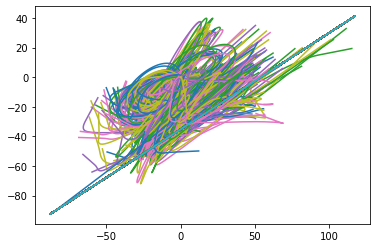

In [124]:
for i in range(len(data)):
    plt.plot(data[i][:,0], data[i][:,1])
    plt.plot(x, y)
plt.show()

In [125]:
def queryRankList(query, reduction_dim, option, max_limit, k=None, r=None): 
    '''
    returns a list; the indices of the trajectories to be retrieved for the query
    '''
    mappedReducedQuery = dimReducedQuery(query, option=option)
    distQueryFromReducedData = LA.norm(reducedData - mappedReducedQuery.reshape(reduction_dim,1), 
                                       axis=0) / (n_x_grids * n_y_grids)
    distQueryFromReducedDataSortedIndices = np.argsort(distQueryFromReducedData)
    if k:
        return distQueryFromReducedDataSortedIndices[:k]
    elif r:
        idx = np.where(distQueryFromReducedData < r)[0]
        return idx[:max_limit]
    else:
        print(colored("Please specify k or r", "yellow"))
        return

In [126]:
def dataRankedLists(data_vectorized, reducedData, option, path=None): 
    # get real dists of data points with grid aggregated distance
    n = len(data)
    distsData = np.zeros((n, n))
    for j in range(n-1):
        distsData[j][j+1:] = gridAggregateDistVectorized(data_vectorized[j], 
                                                         data_vectorized[j+1:], 
                                                         option=option)
    distsData = distsData + distsData.T
    distsDataArgSorts = np.argsort(distsData)
    if path:
        np.savetxt(path+"distsData_"+option+".csv", distsData, delimiter=",")
        np.savetxt(path+"distsDataArgSorts_"+option+".csv", distsDataArgSorts, delimiter=",")

    # get dists of data points after dim reduction
    distsReducedData = np.zeros((n,n))
    for j in range(n-1):
        a = LA.norm(reducedData[j] - reducedData[j+1:], axis=1)/(n_x_grids * n_y_grids)
        distsReducedData[j][j+1:] = a
    distsReducedData = distsReducedData + distsReducedData.T
    distsReducedDataArgSorts = np.argsort(distsReducedData)
    if path:
        np.savetxt(path+"distsReducedData_"+option+".csv", distsReducedData, delimiter=",")
        np.savetxt(path+"distsReducedDataArgSorts_"+option+".csv", distsReducedDataArgSorts, delimiter=",")
    return distsData, distsDataArgSorts, distsReducedData, distsReducedDataArgSorts

In [127]:
start_time = time.time()
print('option:', option)
distsData, distsDataArgSorts, distsReducedData, distsReducedDataArgSorts = \
                        dataRankedLists(D_tilda.T, reducedData.T, option, path)
print(time.time() - start_time) 

option: binary
306.35557556152344


In [128]:
sum(np.argsort(distsData[0]) != np.argsort(distsReducedData[0]))

240

In [129]:
data_ranked_list_dtw = np.argsort(dists_dtw)
data_ranked_list_dtw.shape

(300, 300)

In [130]:
def precisionAndRecallData(data, N, max_limit, distsData, distsDataArgSorts, 
                           distsReducedData, distsReducedDataArgSorts, k=None, r=None): 
    '''
    calculates percision and recall for all data points as well as 
    the average of percision and recall for all data @N (Note: This is not AP)
    This function is not sensitive to k if k>=N.
    Note: Don't give values for both k and r (one of them should be None).
    '''
    percision = np.zeros(len(data))
    recall = np.zeros(len(data))
    if (k and r):
        for j in range(len(data)):
            c = 0
            for i in range(N):
                if distsReducedDataArgSorts[j][i] in distsDataArgSorts[j][:N]:
                    c += 1
            percision[j] = c/N
            recall[j] = c/N
        percision_k = percision.copy()
        recall_k = recall.copy()
        for j in range(len(data)):
            d = 0
            idx = np.where(distsData[j] < r)[0][:min(max_limit, N)]
            idx_red = np.where(distsReducedData[j] < r)[0][:min(max_limit, N)]
            for i in range(len(idx_red)):
                if idx_red[i] in idx:
                    d += 1
            percision[j] = d/len(idx_red)
            recall[j] = d/len(idx)
        return {f"k={k}:": [percision_k, recall_k, np.mean(percision_k), np.mean(recall_k)],
                f"r={r}:": [percision, recall, np.mean(percision), np.mean(recall)]}
    elif k:
        for j in range(len(data)):
            c = 0
            for i in range(N):
                if distsReducedDataArgSorts[j][i] in distsDataArgSorts[j][:N]:
                    c += 1
            percision[j] = c/N
            recall[j] = c/N
        return percision, recall, np.mean(percision), np.mean(recall)
    elif r:
        for j in range(len(data)):
            c = 0
            idx = np.where(distsData[j] < r)[0]
            idx_red = np.where(distsReducedData[j] < r)[0]
            I = np.argsort(distsData[j][idx])
            idx = idx[I][:min(max_limit, N)]
            J = np.argsort(distsReducedData[j][idx_red])
            idx_red = idx_red[J][:min(max_limit, N)]
            for i in range(len(idx_red)):
                if idx_red[i] in idx:
                    c += 1
            percision[j] = c/len(idx_red)
            recall[j] = c/len(idx)
        return percision, recall, np.mean(percision), np.mean(recall)
    else:
        print(colored("Pleas specify the value of k or r.", "yellow"))

### Average of percisions of all data points where each is used as kNN queries

With GAD as ground truth

In [131]:
# Note: for kNN queries percision and recall are the same
print("option:", option)
percision = []
recall = []
mean_percision = []
mean_recall = []

for k in [5, 10, 20]:
    a, b, c, d = precisionAndRecallData(data, N=k, max_limit=50, 
                            distsData=distsData, distsDataArgSorts=distsDataArgSorts, 
                            distsReducedData=distsReducedData, 
                            distsReducedDataArgSorts=distsReducedDataArgSorts, k=k, r=None)
    percision.append(a)
    recall.append(b)
    mean_percision.append(c)
    mean_recall.append(d)

#print(colored(f"percision: {percision}", 'yellow'))
#print("recall:", recall)
print(colored(f"mean_percision: {np.array(mean_percision)}", 'yellow'))
print("mean_recall:", np.array(mean_recall))

option: binary
mean_percision: [0.91066667 0.94       0.95383333]
mean_recall: [0.91066667 0.94       0.95383333]


In [61]:
# Note: for kNN queries percision and recall are the same
print("option:", option)
percision = []
recall = []
mean_percision = []
mean_recall = []

for k in [5, 10, 20]:
    a, b, c, d = precisionAndRecallData(data, N=k, max_limit=50,  
                            distsData=distsData, distsDataArgSorts=distsDataArgSorts, 
                            distsReducedData=distsReducedData, 
                            distsReducedDataArgSorts=distsReducedDataArgSorts, k=k, r=None)
    percision.append(a)
    recall.append(b)
    mean_percision.append(c)
    mean_recall.append(d)

#print(colored(f"percision: {percision}", 'yellow'))
#print("recall:", recall)
print(colored(f"mean_percision: {np.array(mean_percision)}", 'yellow'))
print("mean_recall:", np.array(mean_recall))

option: multipass
mean_percision: [0.83733333 0.83033333 0.84583333]
mean_recall: [0.83733333 0.83033333 0.84583333]


With dtw as ground truth

In [154]:
np.max(dists_dtw/1e5), np.mean(dists_dtw/1e5), np.max(distsData), np.mean(distsData)

(0.018899771820952878,
 0.004341583874847304,
 0.017540528196754328,
 0.00901724674814411)

dtw

In [133]:
# Note: for kNN queries percision and recall are the same
print("option:", option)
percision = []
recall = []
mean_percision = []
mean_recall = []

for k in [5, 10, 20]:
    a, b, c, d = precisionAndRecallData(data, N=k, max_limit=50, 
                            distsData=dists_dtw/1e5, distsDataArgSorts=data_ranked_list_dtw, 
                            distsReducedData=distsReducedData, 
                            distsReducedDataArgSorts=distsReducedDataArgSorts, k=k, r=None)
    percision.append(a)
    recall.append(b)
    mean_percision.append(c)
    mean_recall.append(d)

#print(colored(f"percision: {percision}", 'yellow'))
#print("recall:", recall)
print(colored(f"mean_percision: {np.array(mean_percision)}", 'yellow'))
print("mean_recall:", np.array(mean_recall))

option: binary
mean_percision: [0.606      0.62866667 0.61583333]
mean_recall: [0.606      0.62866667 0.61583333]


dtw

In [67]:
# Note: for kNN queries percision and recall are the same
print("option:", option)
percision = []
recall = []
mean_percision = []
mean_recall = []

for k in [5, 10, 20]:
    a, b, c, d = precisionAndRecallData(data, N=k, max_limit=50, 
                            distsData=dists_dtw/1e4, distsDataArgSorts=data_ranked_list_dtw, 
                            distsReducedData=distsReducedData, 
                            distsReducedDataArgSorts=distsReducedDataArgSorts, k=k, r=None)
    percision.append(a)
    recall.append(b)
    mean_percision.append(c)
    mean_recall.append(d)

#print(colored(f"percision: {percision}", 'yellow'))
#print("recall:", recall)
print(colored(f"mean_percision: {np.array(mean_percision)}", 'yellow'))
print("mean_recall:", np.array(mean_recall))

option: multipass
mean_percision: [0.71466667 0.693      0.63633333]
mean_recall: [0.71466667 0.693      0.63633333]


### Averages of percisions and recalls of all data points where each is used as range queries

In [134]:
np.max(distsData), np.max(distsReducedData)

(0.017540528196754328, 0.017156539508832124)

With GAD as ground truth

In [135]:
print("option:", option)
percision = []
recall = []
mean_percision = []
mean_recall = []

for r in [0.002, 0.005, 0.01]:
    a, b, c, d = precisionAndRecallData(data, N=10, max_limit=50, 
                            distsData=distsData, distsDataArgSorts=distsDataArgSorts, 
                            distsReducedData=distsReducedData, 
                            distsReducedDataArgSorts=distsReducedDataArgSorts, k=None, r=r)
    percision.append(a)
    recall.append(b)
    mean_percision.append(c)
    mean_recall.append(d)

#print(colored(f"percision: {percision}", 'yellow'))
#print("recall:", recall)
print(colored(f"mean_percision: {np.array(mean_percision)}", 'yellow'))
print("mean_recall:", np.array(mean_recall))

option: binary
mean_percision: [0.77196164 0.83718386 0.94      ]
mean_recall: [1.    0.968 0.94 ]


In [89]:
print("option:", option)
percision = []
recall = []
mean_percision = []
mean_recall = []

for r in [0.002, 0.005, 0.01]:
    a, b, c, d = precisionAndRecallData(data, N=10, max_limit=50,
                            distsData=distsData, distsDataArgSorts=distsDataArgSorts, 
                            distsReducedData=distsReducedData, 
                            distsReducedDataArgSorts=distsReducedDataArgSorts, k=None, r=r)
    percision.append(a)
    recall.append(b)
    mean_percision.append(c)
    mean_recall.append(d)

#print(colored(f"percision: {percision}", 'yellow'))
#print("recall:", recall)
print(colored(f"mean_percision: {np.array(mean_percision)}", 'yellow'))
print("mean_recall:", np.array(mean_recall))

option: multipass
mean_percision: [1.         0.97333333 0.81742328]
mean_recall: [1. 1. 1.]


 With dtw as ground truth

In [136]:
print("option:", option)
percision = []
recall = []
mean_percision = []
mean_recall = []

for r in [0.002, 0.005, 0.01]:
    a, b, c, d = precisionAndRecallData(data, N=10, max_limit=50, 
                            distsData=dists_dtw/1e5, distsDataArgSorts=data_ranked_list_dtw, 
                            distsReducedData=distsReducedData, 
                            distsReducedDataArgSorts=distsReducedDataArgSorts, k=None, r=r)
    percision.append(a)
    recall.append(b)
    mean_percision.append(c)
    mean_recall.append(d)

#print(colored(f"percision: {percision}", 'yellow'))
#print("recall:", recall)
print(colored(f"mean_percision: {np.array(mean_percision)}", 'yellow'))
print("mean_recall:", np.array(mean_recall))

option: binary
mean_percision: [0.95335185 0.6541045  0.62866667]
mean_recall: [0.21795503 0.60048148 0.62866667]


In [72]:
print("option:", option)
percision = []
recall = []
mean_percision = []
mean_recall = []

for r in [0.002, 0.005, 0.01]:
    a, b, c, d = precisionAndRecallData(data, N=10, max_limit=50, 
                            distsData=dists_dtw/1e4, distsDataArgSorts=data_ranked_list_dtw, 
                            distsReducedData=distsReducedData, 
                            distsReducedDataArgSorts=distsReducedDataArgSorts, k=None, r=r)
    percision.append(a)
    recall.append(b)
    mean_percision.append(c)
    mean_recall.append(d)

#print(colored(f"percision: {percision}", 'yellow'))
#print("recall:", recall)
print(colored(f"mean_percision: {np.array(mean_percision)}", 'yellow'))
print("mean_recall:", np.array(mean_recall))

option: multipass
mean_percision: [1.         0.99333333 0.99094444]
mean_recall: [0.99333333 0.70894841 0.31017063]


In [137]:
def precisionAndRecallDataPoint(index, N, max_limit, distsData, distsDataArgSorts, 
                                distsReducedData, distsReducedDataArgSorts, k=None, r=None): 
    '''
    calculates percision and recall for one data point (as a query) @ N
    index: the index of data point
    This function is not sensitive to k if k >= N
    '''
    if k:
        c = 0
        for i in range(N):
            if distsReducedDataArgSorts[index][i] in distsDataArgSorts[index][:N]:
                c += 1
        percision = c/N
        recall = c/N
        return percision, recall
    elif r:
        c = 0
        idx = np.where(distsData[index] < r)[0]
        idx_red = np.where(distsReducedData[index] < r)[0]
        I = np.argsort(distsData[index][idx])
        idx = idx[I][:min(max_limit, N)]
        J = np.argsort(distsReducedData[index][idx_red])
        idx_red = idx_red[J][:min(max_limit, N)]
        for i in range(len(idx_red)):
            if idx_red[i] in idx:
                c += 1
        percision = c/len(idx_red)
        recall = c/len(idx)
        return percision, recall
    else:
        print(colored("Pleas specify the value of k or r.", "yellow"))

In [144]:
def averagePrecisionData(data, path, max_limit, reduction_dim, reducedData,  
                         option, k=None, r=None, dtw=False):
    '''
    calculates average percision (AP) for all data points as well as 
    the average of AP on all data points as queries (i.e. MAP)
    path='/content/gdrive/My Drive/IR Project/'
    Note: Don't give values for both k and r (one of them should be None).
    '''
    if dtw:
        distsData = dists_dtw/1e5
        distsDataArgSorts = data_ranked_list_dtw
    else:
        distsData = np.array(pd.read_csv(path+"distsData_"+option+".csv", header=None))
        distsDataArgSorts = np.array(pd.read_csv(path+"distsDataArgSorts_"+option+".csv", header=None))
    
    distsReducedData = np.array(pd.read_csv(path+"distsReducedData_"+option+".csv", header=None))
    distsReducedDataArgSorts = np.array(pd.read_csv(path+"distsReducedDataArgSorts_"+option+".csv", header=None))
    n = len(data)
    AP = np.zeros(n)
    if k:
        AP_temp = np.zeros((k, n))
        for i in range(k):
            percision, _, _, _ = precisionAndRecallData(data, i+1, max_limit,
                                    distsData, distsDataArgSorts, distsReducedData, 
                                    distsReducedDataArgSorts, k=k, r=r)
            for t in range(n):
                if distsReducedDataArgSorts[t][i] in distsDataArgSorts[t]:
                    AP_temp[i][t] = percision[t] 

        AP = np.mean(AP_temp, 0)
        MAP = np.mean(AP)
        return AP, MAP
    elif r:
        for t in range(n):
            AP_temp = []
            s = len(queryRankList(data[t], reduction_dim, option, max_limit, k=None, r=r))
            for i in range(s):
                percision, _ = precisionAndRecallDataPoint(t, i+1, max_limit, 
                                distsData, distsDataArgSorts, distsReducedData, 
                                    distsReducedDataArgSorts, k=None, r=r)
                idx = np.where(distsData[t] < r)[0]
                idx_red = np.where(distsReducedData[t] < r)[0]
                #
                I = np.argsort(distsData[t][idx])
                idx = idx[I][:min(max_limit, i+1)]
                J = np.argsort(distsReducedData[t][idx_red])
                idx_red = idx_red[J][:min(max_limit, i+1)]
                if i < len(idx_red):
                    if idx_red[i] in idx:
                        AP_temp.append(percision)
            AP[t] = np.sum(AP_temp)/s
        MAP = np.mean(AP)
        return AP, MAP

### AP and MAP for kNN queries

#### binary

In [145]:
start_time = time.time()
print("option:", option)
AP = []
MAP = []

for k in [5, 10, 20]:
    a, b = averagePrecisionData(data, path, max_limit, reduction_dim, 
                                reducedData, option, k=k, r=None, dtw=False)
    AP.append(a)
    MAP.append(b)

#print(f"AP: {np.array(AP)}")
print(colored(f"MAP: {np.array(MAP)}", 'yellow'))
print("Total time:", time.time() - start_time)

option: binary
MAP: [0.92235556 0.92840728 0.93958846]
Total time: 1.0617926120758057


dtw

In [146]:
print("option:", option)
start_time = time.time()
AP = []
MAP = []

for k in [5, 10, 20]:
    a, b = averagePrecisionData(data, path, max_limit, reduction_dim, 
                                reducedData, option, k=k, r=None, dtw=True)
    AP.append(a)
    MAP.append(b)

#print(f"AP: {np.array(AP)}")
print(colored(f"MAP: {np.array(MAP)}", 'yellow'))
print("Total time:", time.time() - start_time)

option: binary
MAP: [0.69336667 0.65569815 0.64401549]
Total time: 0.8682894706726074


#### Multipass

In [77]:
start_time = time.time()
print("option:", option)
AP = []
MAP = []

for k in [5, 10, 20]:
    a, b = averagePrecisionData(data, path, max_limit, reduction_dim, 
                                reducedData, option, k=k, r=None, dtw=False)
    AP.append(a)
    MAP.append(b)

#print(f"AP: {np.array(AP)}")
print(colored(f"MAP: {np.array(MAP)}", 'yellow'))
print("Total time:", time.time() - start_time)

option: multipass
MAP: [0.88157778 0.85517341 0.84971811]
Total time: 1.0995688438415527


dtw

In [78]:
print("option:", option)
start_time = time.time()
AP = []
MAP = []

for k in [5, 10, 20]:
    a, b = averagePrecisionData(data, path, max_limit, reduction_dim, 
                                reducedData, option, k=k, r=None, dtw=True)
    AP.append(a)
    MAP.append(b)

#print(f"AP: {np.array(AP)}")
print(colored(f"MAP: {np.array(MAP)}", 'yellow'))
print("Total time:", time.time() - start_time)

option: multipass
MAP: [0.79498889 0.74526534 0.7039571 ]
Total time: 0.9592134952545166


### AP and MAP for range queries

#### binary

In [152]:
start_time = time.time()
print("option:", option)
AP = []
MAP = []

for r in [0.002, 0.005, 0.01]:
    s = time.time()
    a, b = averagePrecisionData(data, path, max_limit, reduction_dim, 
                                reducedData, option, k=None, r=r, dtw=False)
    AP.append(a)
    MAP.append(b)
    print(f"time for {r}: {time.time() - s}")
    
#print(f"AP: {np.array(AP)}")
print(colored(f"MAP: {np.array(MAP)}", 'yellow'))
print(time.time() - start_time)

option: binary
time for 0.002: 288.7272415161133
time for 0.005: 290.4938750267029
time for 0.01: 293.78574800491333
MAP: [0.76557037 0.54504829 0.65671971]
873.0133354663849


dtw

In [153]:
start_time = time.time()
print("option:", option)
AP = []
MAP = []

for r in [0.002, 0.005, 0.01]:
    s = time.time()
    a, b = averagePrecisionData(data, path, max_limit, reduction_dim, 
                                reducedData, option, k=None, r=r, dtw=True)
    AP.append(a)
    MAP.append(b)
    print(f"time for {r}: {time.time() - s}")
    
#print(f"AP: {np.array(AP)}")
print(colored(f"MAP: {np.array(MAP)}", 'yellow'))
print(time.time() - start_time)

option: binary
time for 0.002: 289.46222972869873
time for 0.005: 290.696076631546
time for 0.01: 294.1274983882904
MAP: [0.79028378 0.31705136 0.2188535 ]
874.2943816184998


#### Multipass

In [85]:
start_time = time.time()
print("option:", option)
AP = []
MAP = []

for r in [0.002, 0.005, 0.01]:
    s = time.time()
    a, b = averagePrecisionData(data, path, max_limit, reduction_dim, 
                                reducedData, option, k=None, r=r, dtw=False)
    AP.append(a)
    MAP.append(b)
    print(f"time for {r}: {time.time() - s}")
    
#print(f"AP: {np.array(AP)}")
print(colored(f"MAP: {np.array(MAP)}", 'yellow'))
print(time.time() - start_time)

option: multipass
time for 0.002: 291.84781551361084
time for 0.005: 291.030962228775
time for 0.01: 290.595148563385
MAP: [1.         0.97333333 0.81742328]
873.4807262420654


dtw

In [86]:
start_time = time.time()
print("option:", option)
AP = []
MAP = []

for r in [0.002, 0.005, 0.01]:
    s = time.time()
    a, b = averagePrecisionData(data, path, max_limit, reduction_dim, 
                                reducedData, option, k=None, r=r, dtw=True)
    AP.append(a)
    MAP.append(b)
    print(f"time for {r}: {time.time() - s}")
    
#print(f"AP: {np.array(AP)}")
print(colored(f"MAP: {np.array(MAP)}", 'yellow'))
print(time.time() - start_time)

option: multipass
time for 0.002: 290.7748327255249
time for 0.005: 291.3804612159729
time for 0.01: 291.0939803123474
MAP: [1.         0.99333333 0.92715605]
873.255045413971


## nDCG

In [147]:
def nDCG(data, path, max_limit, reduction_dim, option, N, k=None, r=None, dtw=False):
    '''
    calculates average nDCG @N for all data points as well as 
    the average of nDCG @N on all data points as queries;
    N should be <= k;
    path='/content/gdrive/My Drive/IR Project/Characters/'
    Note: Don't give values for both k and r (one of them should be None).
    '''
    if dtw:
        distsData = dists_dtw/1e5
        distsDataArgSorts = data_ranked_list_dtw
    else:
        distsData = np.array(pd.read_csv(path+"distsData_"+option+".csv", header=None))
        distsDataArgSorts = np.array(pd.read_csv(path+"distsDataArgSorts_"+option+".csv", header=None))
        
    distsReducedData = np.array(pd.read_csv(path+"distsReducedData_"+option+".csv", header=None))
    distsReducedDataArgSorts = np.array(pd.read_csv(path+"distsReducedDataArgSorts_"+option+".csv", header=None))
    DCG = np.zeros(len(data))
    if k: 
        iDCG = np.sum([(k-i)/math.log(i+2, 2) for i in range(k)])
        for j in range(len(data)):
            rel = np.zeros(N)
            for i in range(N):
                if distsReducedDataArgSorts[j][i] in distsDataArgSorts[j]:
                    if k - distsDataArgSorts[j].tolist().index(distsReducedDataArgSorts[j][i]) > 0:
                        rel[i] = k - distsDataArgSorts[j].tolist().index(distsReducedDataArgSorts[j][i])
            DCG[j] = np.sum([rel[i]/math.log(i+2, 2) for i in range(N)])
        return DCG/iDCG, np.mean(DCG/iDCG)
    elif r:
        relevance = list(reversed(range(1, N+1)))
        iDCG = np.sum([relevance[i]/math.log(i+2, 2) for i in range(N)])
        for j in range(len(data)):
            I = np.where(distsData[j] < r)[0]
            relevant = distsDataArgSorts[j][:len(I)]
            J = np.where(distsReducedData[j] < r)[0]
            retrieved = distsReducedDataArgSorts[j][:len(J)]
            rel = np.zeros(N)
            for i in range(N):
                if distsReducedDataArgSorts[j][i] in distsReducedDataArgSorts[j][:len(I)]:
                    if N - distsDataArgSorts[j].tolist().index(distsReducedDataArgSorts[j][i]) > 0:
                        rel[i] = N - distsDataArgSorts[j].tolist().index(distsReducedDataArgSorts[j][i])
            DCG[j] = np.sum([rel[i]/math.log(i+2, 2) for i in range(N)])
        return DCG/iDCG, np.mean(DCG/iDCG)

### nDCG for binary

In [148]:
# N <= k
print("option:", option)
nDCGs = []
for k in [5, 10, 20]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=5, k=k, 
                      r=None, dtw=False)[1])
print(colored(f'nDCGs: {np.array(nDCGs)}', 'yellow'))

nDCGs = []
for k in [5, 10, 20]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=10, k=k, 
                      r=None, dtw=False)[1])
print(colored(f'nDCGs: {np.array(nDCGs)}', 'yellow'))

option: binary
nDCGs: [0.96666363 0.81760178 0.60246823]
nDCGs: [0.98778374 0.98377613 0.8334186 ]


dtw

In [149]:
# N <= k
print("option:", option)
nDCGs = []
for k in [5, 10, 20]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=5, k=k, 
                      r=None, dtw=True)[1])
print(colored(f'nDCGs: {np.array(nDCGs)}', 'yellow'))

nDCGs = []
for k in [5, 10, 20]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=10, k=k, 
                      r=None, dtw=True)[1])
print(colored(f'nDCGs: {np.array(nDCGs)}', 'yellow'))

option: binary
nDCGs: [0.77113168 0.65041226 0.5084277 ]
nDCGs: [0.84881542 0.7791519  0.66391847]


In [150]:
print("option:", option)
nDCGs = []
for r in [0.002, 0.005, 0.01]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=5, k=None,
                      r=r, dtw=False)[1])
print(colored(f'nDCGs@5: {np.array(nDCGs)}', 'yellow'))

nDCGs = []
for r in [0.002, 0.005, 0.01]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=10, k=None,
                      r=r, dtw=False)[1])
print(colored(f'nDCGs@10: {np.array(nDCGs)}', 'yellow'))

option: binary
nDCGs@5: [0.56238751 0.9350652  0.96666363]
nDCGs@10: [0.40097875 0.90668319 0.98377613]


dtw

In [151]:
print("option:", option)
nDCGs = []
for r in [0.002, 0.005, 0.01]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=5, k=None,
                      r=r, dtw=True)[1])
print(colored(f'nDCGs@5: {np.array(nDCGs)}', 'yellow'))

nDCGs = []
for r in [0.002, 0.005, 0.01]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=10, k=None,
                      r=r, dtw=True)[1])
print(colored(f'nDCGs@10: {np.array(nDCGs)}', 'yellow'))

option: binary
nDCGs@5: [0.76960775 0.77113168 0.77113168]
nDCGs@10: [0.77461399 0.7791519  0.7791519 ]


### nDCG for multipass

In [91]:
# N <= k
print("option:", option)
nDCGs = []
for k in [5, 10, 20]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=5, k=k, 
                      r=None, dtw=False)[1])
print(colored(f'nDCGs: {np.array(nDCGs)}', 'yellow'))

nDCGs = []
for k in [5, 10, 20]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=10, k=k, 
                      r=None, dtw=False)[1])
print(colored(f'nDCGs: {np.array(nDCGs)}', 'yellow'))

option: multipass
nDCGs: [0.93271826 0.78335544 0.5833734 ]
nDCGs: [0.96943947 0.93556659 0.78782557]


dtw

In [92]:
# N <= k
print("option:", option)
nDCGs = []
for k in [5, 10, 20]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=5, k=k, 
                      r=None, dtw=True)[1])
print(colored(f'nDCGs: {np.array(nDCGs)}', 'yellow'))

nDCGs = []
for k in [5, 10, 20]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=10, k=k, 
                      r=None, dtw=True)[1])
print(colored(f'nDCGs: {np.array(nDCGs)}', 'yellow'))

option: multipass
nDCGs: [0.85777991 0.72025125 0.54511398]
nDCGs: [0.91201112 0.84508284 0.70487617]


In [93]:
print("option:", option)
nDCGs = []
for r in [0.002, 0.005, 0.01]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=5, k=None,
                      r=r, dtw=False)[1])
print(colored(f'nDCGs@5: {np.array(nDCGs)}', 'yellow'))

nDCGs = []
for r in [0.002, 0.005, 0.01]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=10, k=None,
                      r=r, dtw=False)[1])
print(colored(f'nDCGs@10: {np.array(nDCGs)}', 'yellow'))

option: multipass
nDCGs@5: [0.48676368 0.48676368 0.50672807]
nDCGs@10: [0.33371032 0.33371032 0.34938626]


dtw

In [94]:
print("option:", option)
nDCGs = []
for r in [0.002, 0.005, 0.01]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=5, k=None,
                      r=r, dtw=True)[1])
print(colored(f'nDCGs@5: {np.array(nDCGs)}', 'yellow'))

nDCGs = []
for r in [0.002, 0.005, 0.01]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=10, k=None,
                      r=r, dtw=True)[1])
print(colored(f'nDCGs@10: {np.array(nDCGs)}', 'yellow'))

option: multipass
nDCGs@5: [0.49003956 0.62933385 0.83408243]
nDCGs@10: [0.3362369  0.47211418 0.76736183]
